# Random Forest Training Size Analysis for Mass Spectrometry Prediction

This notebook provides a comprehensive analysis of how Random Forest model performance scales with training data size for mass spectrometry prediction. We systematically train models on varying percentages of training data (10%, 20%, ..., 100%) and evaluate their performance on a fixed test set.

## Research Questions:

### 1. Performance Scaling
How does model performance (measured by cosine similarity) scale with training data size?

$$\text{Performance} = f(\text{Training Size})$$

### 2. Data Efficiency
What is the minimum amount of training data needed to achieve acceptable performance?

$$\min_{n} \{n : \text{Cosine}(n) \geq \tau\}$$

Where $\tau$ is the acceptable performance threshold.

### 3. Diminishing Returns
At what point do we observe diminishing returns from additional training data?

$$\frac{\partial \text{Performance}}{\partial n} < \epsilon$$

### 4. m/z Range Effects
How do different mass-to-charge (m/z) ranges respond to varying training data sizes?

## Methodology:

**Random Forest for Multi-Output Regression:**

Random Forest builds $T$ decision trees and aggregates their predictions:

$$\hat{y} = \frac{1}{T} \sum_{t=1}^{T} h_t(x)$$

Where:
- $T$ = number of trees (n_estimators)
- $h_t$ = individual tree predictor trained on bootstrap sample $t$
- Each tree sees ~63.2% unique samples (bootstrap property)

**Data Sampling Strategy:**

For each percentage $p \in \{10, 20, ..., 100\}$:
1. Sample $n_p = \lfloor p \cdot N_{train} / 100 \rfloor$ training examples
2. Train RF model on sampled data
3. Evaluate on full test set

**Input Requirements**: 
- Featurized JSONL data from preprocessing pipeline
- Train/validation/test splits

**Output**: 
- Trained models for each data percentage
- Performance metrics and visualizations
- Statistical analysis of scaling behavior

## 1. Environment Setup

Import required libraries and configure the computational environment.

### Key Components:

**Scientific Computing:**
- **NumPy**: Numerical operations on spectral data
- **Pandas**: Structured data manipulation and analysis
- **SciPy**: Statistical functions and optimization routines

**Machine Learning:**
- **scikit-learn**: Random Forest implementation and evaluation metrics
- **StandardScaler**: Feature normalization to zero mean and unit variance

**Visualization:**
- **Matplotlib/Seaborn**: Performance curves and distribution analysis
- **Interpolation**: Smooth curve fitting for trend visualization

**Parallel Processing:**
- **ThreadPoolExecutor**: Concurrent data loading and model training
- Utilizes all available CPU cores for Random Forest training

In [2]:
# Standard library imports
import os
import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.interpolate import make_interp_spline
import scipy.stats as stats

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    median_absolute_error, explained_variance_score
)

# Configure warnings and logging
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete")

Environment setup complete


## 2. Configuration

Central configuration for the training size analysis pipeline.

### Configuration Parameters:

**Data Settings:**
- `transform_sqrt`: Apply square root transformation to stabilize variance
  $$y_{transformed} = \sqrt{y_{original}}$$
  This transformation helps with high-intensity peaks that dominate MSE
- `training_percentages`: List of data fractions to evaluate
- `random_state`: Seed for reproducible sampling

**Random Forest Hyperparameters:**
- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum tree depth (controls model complexity)
- `min_samples_split`: Minimum samples to split internal node
- `min_samples_leaf`: Minimum samples in leaf node

**Evaluation Settings:**
- `mz_step`: Bin size for m/z range analysis
- `max_mz`: Maximum m/z value to consider
- `peak_threshold`: Minimum relative intensity for peak detection
- `mz_ranges_of_interest`: Specific ranges for detailed analysis

### Hyperparameter Rationale:

The chosen hyperparameters balance:
1. **Model Capacity**: Deep trees (max_depth=25) can capture complex patterns
2. **Regularization**: min_samples_split=3 prevents overfitting to noise
3. **Computational Efficiency**: 100 trees provides good ensemble performance

In [3]:
CONFIG = {
    # Paths configuration
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models/training_size_analysis',
        'input_type': 'hpj',
        'use_selected_data': False,
        'data_subdir': lambda use_sel: 'selected' if use_sel else 'full_featurised'
    },
    
    # Data settings
    'data': {
        'random_state': 42,
        'transform_sqrt': True,  # Square root transformation for variance stabilization
        'training_percentages': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    },
    
    # Random Forest hyperparameters
    'rf': {
        'n_estimators': 100,  # Number of trees in the forest
        'max_depth': 25,      # Maximum depth of trees
        'min_samples_split': 3,  # Minimum samples to split internal node
        'min_samples_leaf': 1,   # Minimum samples in leaf node
        'n_jobs': -1  # Use all available CPU cores
    },
    
    # Evaluation settings
    'evaluation': {
        'mz_step': 50,  # m/z range bin size
        'max_mz': 1000,  # Maximum m/z to analyze
        'peak_threshold': 0.01,  # 1% relative intensity threshold
        'mz_ranges_of_interest': [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500)]
    }
}

# Create models directory
os.makedirs(CONFIG['paths']['models_dir'], exist_ok=True)

# Display configuration summary
print("Configuration Summary:")
print("=" * 50)
print(f"Models directory: {CONFIG['paths']['models_dir']}")
print(f"Training percentages: {CONFIG['data']['training_percentages']}")
print(f"Random Forest parameters:")
for key, value in CONFIG['rf'].items():
    print(f"  {key}: {value}")
print(f"\nTotal experiments to run: {len(CONFIG['data']['training_percentages'])}")

Configuration Summary:
Models directory: ../models/training_size_analysis
Training percentages: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Random Forest parameters:
  n_estimators: 100
  max_depth: 25
  min_samples_split: 3
  min_samples_leaf: 1
  n_jobs: -1

Total experiments to run: 10


## 3. Data Loading and Utility Functions

Core utilities for data manipulation, model evaluation, and performance metrics.

### Key Functions:

#### 3.1 Data Loading

**`load_jsonl_data`**: Efficiently loads JSONL files containing:
- SMILES strings (molecular representations)
- Feature vectors (molecular descriptors)
- Target spectra (intensity values at each m/z)

#### 3.2 Data Sampling

**`sample_training_data`**: Implements stratified random sampling
- Ensures reproducible subsets using fixed random seed
- Maintains data distribution across samples

#### 3.3 Evaluation Metrics

**Cosine Similarity**:
Primary metric for spectral comparison, invariant to absolute intensity:

$$\text{cosine\_similarity}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\mathbf{y} \cdot \hat{\mathbf{y}}}{||\mathbf{y}|| \cdot ||\hat{\mathbf{y}}||}$$

Where:
- $\mathbf{y}$ = true spectrum vector
- $\hat{\mathbf{y}}$ = predicted spectrum vector
- $\cdot$ = dot product
- $||\cdot||$ = L2 norm

**Standard Regression Metrics**:
- MSE: $\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
- RMSE: $\sqrt{\text{MSE}}$
- R²: $1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$
- MAE: $\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$

#### 3.4 m/z Range Analysis

**`cosine_similarity_by_mz_range`**: Evaluates performance across mass ranges
- Identifies model strengths/weaknesses at different m/z values
- Calculates coverage (% samples with peaks in range)
- Tracks peak detection accuracy

In [4]:
def get_data_paths(config: Dict[str, Any]) -> Dict[str, str]:
    """Get data file paths based on configuration.
    
    Args:
        config: Configuration dictionary
        
    Returns:
        Dictionary mapping dataset names to file paths
    """
    input_type_dir = os.path.join(config['paths']['results_dir'], config['paths']['input_type'])
    data_dir = os.path.join(input_type_dir, config['paths']['data_subdir'](config['paths']['use_selected_data']))
    
    return {
        'train': os.path.join(data_dir, 'train_data.jsonl'),
        'val': os.path.join(data_dir, 'val_data.jsonl'),
        'test': os.path.join(data_dir, 'test_data.jsonl')
    }

def load_jsonl_data(filepath: str) -> Tuple[List[str], np.ndarray, np.ndarray]:
    """Load data from JSONL file.
    
    Args:
        filepath: Path to JSONL file
        
    Returns:
        Tuple of (SMILES list, feature array, target array)
    """
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)
    
    # Count lines for progress bar
    with open(filepath, 'r') as f:
        total_lines = sum(1 for _ in f)
    
    # Load data with progress tracking
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}", 
                       total=total_lines, unit="spectra"):
            try:
                record = json.loads(line)
                smiles = record.get("smiles")
                feat = record.get("features")
                targ = record.get("target")
                
                if smiles and feat is not None and targ is not None:
                    smiles_list.append(smiles)
                    features.append(feat)
                    targets.append(targ)
            except (json.JSONDecodeError, KeyError) as e:
                continue
    
    print(f"Loaded {len(smiles_list)} samples from {os.path.basename(filepath)}")
    return smiles_list, np.array(features), np.array(targets)

def sample_training_data(X_train: np.ndarray, y_train: np.ndarray, 
                        smiles_train: List[str], percentage: float, 
                        random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Sample a percentage of training data with fixed random seed.
    
    Args:
        X_train: Training features
        y_train: Training targets
        smiles_train: Training SMILES strings
        percentage: Percentage of data to sample (0-100)
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (sampled features, sampled targets, sampled SMILES)
    """
    n_samples = int(len(X_train) * percentage / 100)
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    
    return X_train[indices], y_train[indices], [smiles_train[i] for i in indices]

def cosine_similarity_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, np.ndarray]:
    """Calculate cosine similarity between true and predicted spectra.
    
    Cosine similarity measures the angle between two vectors, making it
    invariant to absolute intensity scaling.
    
    Args:
        y_true: True spectra array (n_samples, n_features)
        y_pred: Predicted spectra array (n_samples, n_features)
        
    Returns:
        Tuple of (mean similarity, array of individual similarities)
    """
    similarities = []
    
    for i in range(len(y_true)):
        true_spec = y_true[i]
        pred_spec = y_pred[i]
        
        # Handle edge cases
        if np.sum(true_spec) == 0 or np.sum(pred_spec) == 0:
            cos_sim = 0 if np.sum(true_spec) != np.sum(pred_spec) else 1
        else:
            cos_sim = 1 - cosine(true_spec, pred_spec)
        
        similarities.append(cos_sim if not np.isnan(cos_sim) else 0)
    
    return np.mean(similarities), np.array(similarities)

def cosine_similarity_by_mz_range(y_true: np.ndarray, y_pred: np.ndarray, 
                                 config: Dict[str, Any]) -> Dict[str, Dict[str, Any]]:
    """Calculate cosine similarity for different m/z ranges.
    
    This analysis helps identify which mass ranges the model
    performs well or poorly on.
    
    Args:
        y_true: True spectra
        y_pred: Predicted spectra
        config: Configuration dictionary
        
    Returns:
        Dictionary mapping m/z ranges to performance metrics
    """
    spectrum_length = y_true.shape[1]
    step_size = config['evaluation']['mz_step']
    max_mz = min(config['evaluation']['max_mz'], spectrum_length)
    
    mz_ranges = {}
    
    for start in range(0, max_mz, step_size):
        end = min(start + step_size, max_mz)
        range_key = f"{start}-{end}"
        
        # Extract m/z range
        y_true_range = y_true[:, start:end]
        y_pred_range = y_pred[:, start:end]
        
        similarities = []
        non_zero_samples = 0
        true_peaks = 0
        pred_peaks = 0
        
        for i in range(len(y_true)):
            true_sum = np.sum(y_true_range[i])
            pred_sum = np.sum(y_pred_range[i])
            
            # Count peaks (non-zero values)
            true_peaks += np.sum(y_true_range[i] > 0)
            pred_peaks += np.sum(y_pred_range[i] > 0)
            
            # Count samples with non-zero intensity in this range
            if true_sum > 0 or pred_sum > 0:
                non_zero_samples += 1
            
            # Calculate cosine similarity
            if true_sum == 0 or pred_sum == 0:
                sim = 0 if true_sum != pred_sum else 1
            else:
                sim = 1 - cosine(y_true_range[i], y_pred_range[i])
            similarities.append(sim)
        
        mz_ranges[range_key] = {
            'mean_similarity': np.mean(similarities),
            'std_similarity': np.std(similarities),
            'non_zero_samples': non_zero_samples,
            'total_samples': len(y_true),
            'coverage': non_zero_samples / len(y_true) * 100,
            'true_peaks': int(true_peaks),
            'pred_peaks': int(pred_peaks),
            'avg_true_peaks_per_spectrum': true_peaks / len(y_true),
            'avg_pred_peaks_per_spectrum': pred_peaks / len(y_true)
        }
    
    return mz_ranges

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, 
                  config: Dict[str, Any]) -> Dict[str, Any]:
    """Comprehensive model evaluation with multiple metrics.
    
    Calculates:
    - Cosine similarity (primary metric)
    - Standard regression metrics (MSE, R², MAE)
    - m/z range-specific performance
    - Statistical distributions
    
    Args:
        y_true: True spectra
        y_pred: Predicted spectra
        config: Configuration dictionary
        
    Returns:
        Dictionary containing all evaluation metrics
    """
    # Calculate standard regression metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    explained_var = explained_variance_score(y_true, y_pred)
    
    # Calculate cosine similarity
    mean_cosine_sim, all_cosine_sims = cosine_similarity_matrix(y_true, y_pred)
    
    # Calculate cosine similarity by m/z range
    mz_range_sims = cosine_similarity_by_mz_range(y_true, y_pred, config)
    
    # Calculate percentiles for cosine similarity distribution
    cos_percentiles = np.percentile(all_cosine_sims, [10, 25, 50, 75, 90])
    
    return {
        'cosine': mean_cosine_sim,
        'cosine_std': np.std(all_cosine_sims),
        'cosine_percentiles': cos_percentiles,
        'individual_cos_sims': all_cosine_sims,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'median_ae': median_ae,
        'max_err': max_err,
        'explained_var': explained_var,
        'mz_range_sims': mz_range_sims,
        'rmse': np.sqrt(mse)
    }

print("Utility functions loaded successfully")

Utility functions loaded successfully


## 4. Training on Different Data Percentages

Main experimental loop: train Random Forest models on varying amounts of training data.

### Training Process:

For each percentage $p \in \{10\%, 20\%, ..., 100\%\}$:

1. **Data Sampling**:
   - Sample $n_p = \lfloor p \cdot N_{train} / 100 \rfloor$ training examples
   - Use fixed random seed for reproducible subsets

2. **Preprocessing**:
   - Apply square root transformation: $y \rightarrow \sqrt{y}$
   - Standardize features: $x' = \frac{x - \mu}{\sigma}$

3. **Model Training**:
   - Train Random Forest with fixed hyperparameters
   - Each tree sees bootstrap sample of size $n_p$

4. **Evaluation**:
   - Predict on full test set (constant across all experiments)
   - Calculate comprehensive metrics

### Key Insights:

This experiment reveals:
- **Learning Curve**: How performance improves with more data
- **Data Efficiency**: Minimum data for acceptable performance
- **Saturation Point**: Where additional data yields minimal gains

### Storage:

Each model is saved with:
- Trained Random Forest model
- Feature scaler
- Training metadata
- Evaluation results

In [5]:
print("RANDOM FOREST TRAINING SIZE ANALYSIS")
print("=" * 60)

# Load full datasets
paths = get_data_paths(CONFIG)
train_smiles, X_train_full, y_train_full = load_jsonl_data(paths['train'])
test_smiles, X_test, y_test = load_jsonl_data(paths['test'])

if len(X_train_full) == 0 or len(X_test) == 0:
    print("Error: No data loaded!")
else:
    print(f"\nFull Data Summary:")
    print(f"   Total training samples: {len(X_train_full):,}")
    print(f"   Test samples: {len(X_test):,}")
    print(f"   Feature dimensions: {X_train_full.shape[1]}")
    print(f"   Spectrum dimensions: {y_train_full.shape[1]}")
    
    # Apply transformation to full test set
    if CONFIG['data']['transform_sqrt']:
        y_test_transformed = np.sqrt(y_test)
        print("   Applied square root transformation to targets")
    else:
        y_test_transformed = y_test
    
    # Storage for results
    all_results = {}
    models_info = {}
    
    # Train models on different percentages
    for percentage in CONFIG['data']['training_percentages']:
        print(f"\n{'='*60}")
        print(f"Training on {percentage}% of data")
        print(f"{'='*60}")
        
        # Sample training data
        X_train, y_train, sampled_smiles = sample_training_data(
            X_train_full, y_train_full, train_smiles, percentage, 
            random_state=CONFIG['data']['random_state']
        )
        
        print(f"Sampled {len(X_train):,} training examples ({percentage}% of {len(X_train_full):,})")
        
        # Apply transformation
        if CONFIG['data']['transform_sqrt']:
            y_train_transformed = np.sqrt(y_train)
        else:
            y_train_transformed = y_train
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train Random Forest
        print(f"\nTraining Random Forest...")
        print(f"  Trees: {CONFIG['rf']['n_estimators']}")
        print(f"  Max depth: {CONFIG['rf']['max_depth']}")
        print(f"  Min samples split: {CONFIG['rf']['min_samples_split']}")
        
        rf_model = RandomForestRegressor(
            n_estimators=CONFIG['rf']['n_estimators'],
            max_depth=CONFIG['rf']['max_depth'],
            min_samples_split=CONFIG['rf']['min_samples_split'],
            min_samples_leaf=CONFIG['rf']['min_samples_leaf'],
            random_state=CONFIG['data']['random_state'],
            n_jobs=CONFIG['rf']['n_jobs'],
            verbose=0
        )
        
        # Fit model
        rf_model.fit(X_train_scaled, y_train_transformed)
        print("  Training complete!")
        
        # Predict on test set
        print("\nEvaluating on test set...")
        y_test_pred = rf_model.predict(X_test_scaled)
        y_test_pred = np.maximum(y_test_pred, 0)  # Ensure non-negative intensities
        
        # Evaluate
        results = evaluate_model(y_test_transformed, y_test_pred, CONFIG)
        
        # Store results
        all_results[percentage] = results
        models_info[percentage] = {
            'n_train_samples': len(X_train),
            'model': rf_model,
            'scaler': scaler,
            'sampled_indices': sampled_smiles
        }
        
        # Print summary
        print(f"\nResults for {percentage}% training data:")
        print(f"  Cosine Similarity: {results['cosine']:.4f} ± {results['cosine_std']:.4f}")
        print(f"  R² Score: {results['r2']:.4f}")
        print(f"  RMSE: {results['rmse']:.4f}")
        print(f"  MAE: {results['mae']:.4f}")
        print(f"  Percentiles (10th, 50th, 90th): "
              f"{results['cosine_percentiles'][0]:.3f}, "
              f"{results['cosine_percentiles'][2]:.3f}, "
              f"{results['cosine_percentiles'][4]:.3f}")
        
        # Save model
        model_path = os.path.join(CONFIG['paths']['models_dir'], 
                                  f"rf_model_{percentage}pct.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump({
                'model': rf_model,
                'scaler': scaler,
                'percentage': percentage,
                'n_samples': len(X_train),
                'results': results
            }, f)
        print(f"  Model saved to {model_path}")
    
    print("\n" + "="*60)
    print("All models trained successfully!")
    print("="*60)

RANDOM FOREST TRAINING SIZE ANALYSIS


Loading train_data.jsonl: 100%|██████████| 2176/2176 [00:00<00:00, 2229.95spectra/s]


Loaded 2176 samples from train_data.jsonl


Loading test_data.jsonl: 100%|██████████| 272/272 [00:00<00:00, 2351.94spectra/s]


Loaded 272 samples from test_data.jsonl

Full Data Summary:
   Total training samples: 2,176
   Test samples: 272
   Feature dimensions: 7137
   Spectrum dimensions: 500
   Applied square root transformation to targets

Training on 10% of data
Sampled 217 training examples (10% of 2,176)

Training Random Forest...
  Trees: 100
  Max depth: 25
  Min samples split: 3
  Training complete!

Evaluating on test set...

Results for 10% training data:
  Cosine Similarity: 0.6525 ± 0.1348
  R² Score: 0.0221
  RMSE: 0.0799
  MAE: 0.0323
  Percentiles (10th, 50th, 90th): 0.488, 0.651, 0.831
  Model saved to ../models/training_size_analysis/rf_model_10pct.pkl

Training on 20% of data
Sampled 435 training examples (20% of 2,176)

Training Random Forest...
  Trees: 100
  Max depth: 25
  Min samples split: 3
  Training complete!

Evaluating on test set...

Results for 20% training data:
  Cosine Similarity: 0.6863 ± 0.1378
  R² Score: 0.0065
  RMSE: 0.0761
  MAE: 0.0303
  Percentiles (10th, 50th, 90t

## 5. Performance Visualization

Comprehensive visualization of how model performance scales with training data size.

### Visualization Components:

#### 5.1 Cosine Similarity Learning Curve
Shows primary metric with error bars representing standard deviation.
Smooth interpolation reveals the underlying trend.

#### 5.2 Multiple Metrics Comparison
Dual-axis plot comparing:
- R² Score (correlation strength)
- RMSE (absolute error magnitude)

#### 5.3 Sample Count Visualization
Relates absolute sample count to performance, revealing the data-performance relationship.

#### 5.4 Marginal Performance Gains
Critical for identifying diminishing returns:

$$\text{Marginal Gain} = \frac{\Delta \text{Performance}}{\Delta \text{Data\%}} \times 10$$

Where the gain is normalized per 10% increase in data.

### Key Insights:

These visualizations reveal:
1. **Saturation behavior**: Performance plateaus at certain data sizes
2. **Efficiency regions**: Where small data increases yield large gains
3. **Optimal training size**: Balance between performance and computational cost

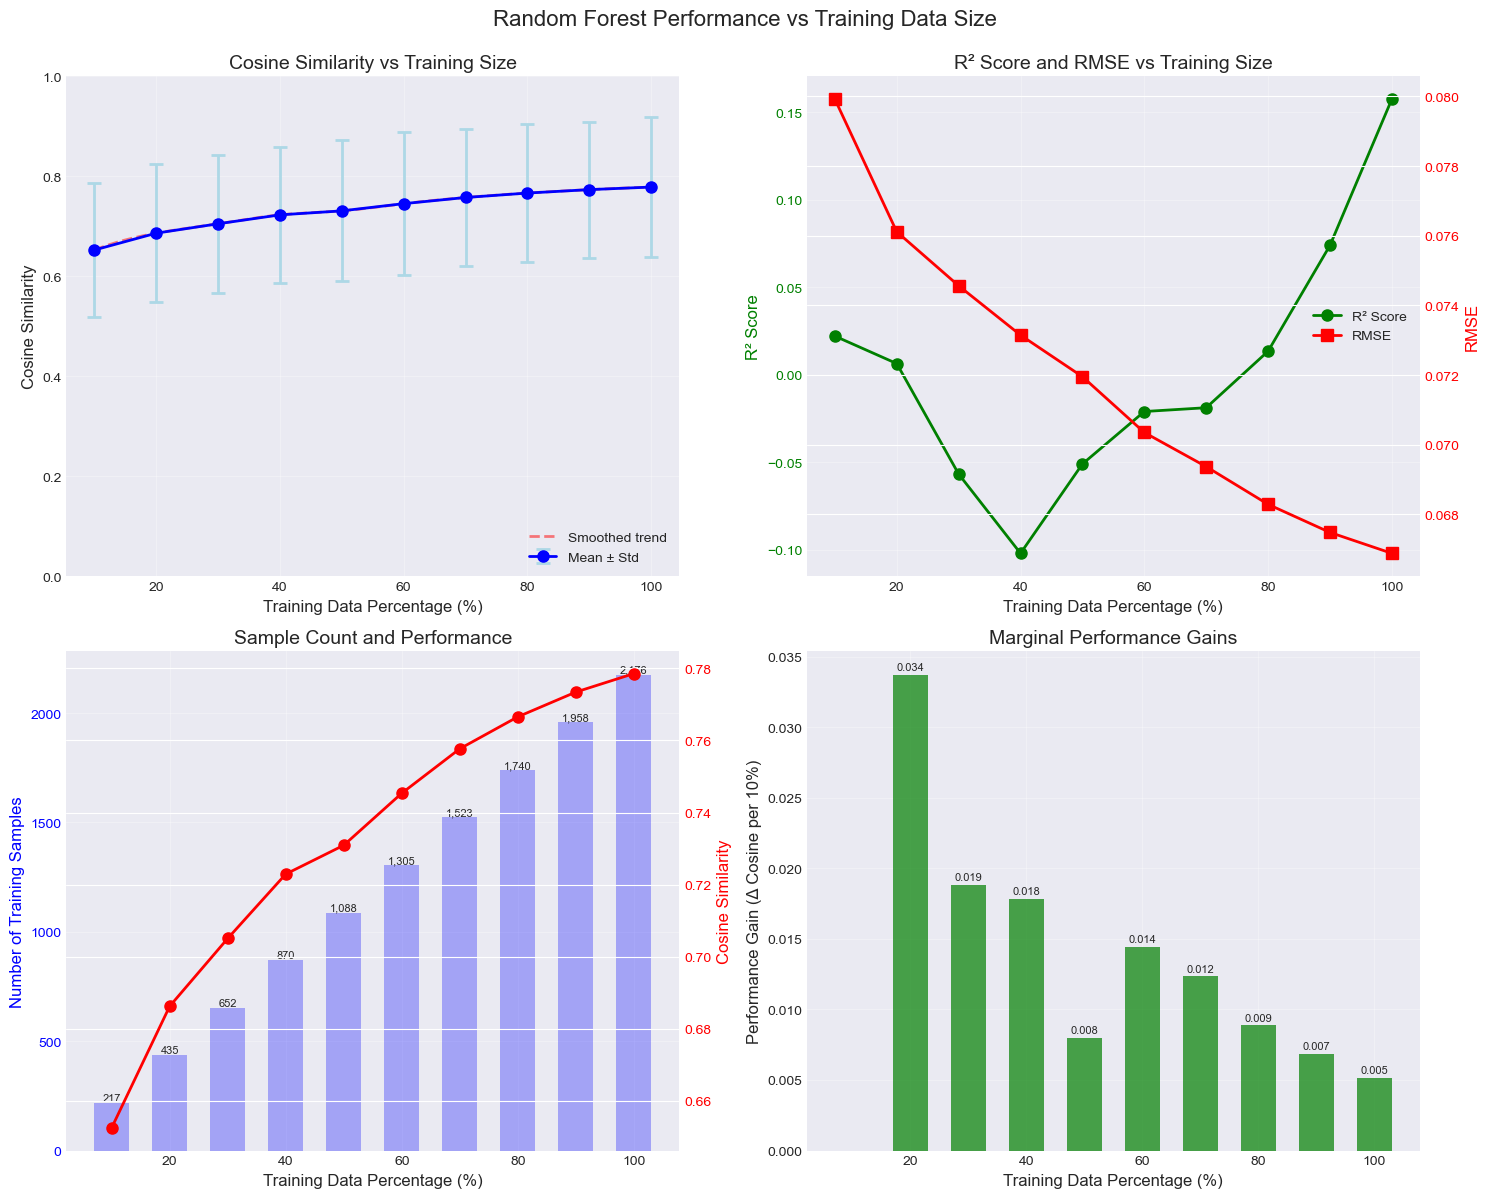


PERFORMANCE SUMMARY TABLE
 Training %  N Samples    Cosine Sim      R²   RMSE    MAE
         10        217 0.6525±0.1348  0.0221 0.0799 0.0323
         20        435 0.6863±0.1378  0.0065 0.0761 0.0303
         30        652 0.7051±0.1383 -0.0566 0.0746 0.0292
         40        870 0.7229±0.1362 -0.1019 0.0731 0.0282
         50       1088 0.7309±0.1412 -0.0509 0.0720 0.0277
         60       1305 0.7454±0.1437 -0.0209 0.0704 0.0267
         70       1523 0.7577±0.1379 -0.0187 0.0694 0.0262
         80       1740 0.7666±0.1385  0.0135 0.0683 0.0257
         90       1958 0.7734±0.1363  0.0739 0.0675 0.0254
        100       2176 0.7786±0.1408  0.1575 0.0669 0.0249

Overall Performance Improvement:
  From 10% to 100% data: +0.1260 (19.3% relative)


In [6]:
# Extract metrics for visualization
percentages = CONFIG['data']['training_percentages']
cosine_scores = [all_results[p]['cosine'] for p in percentages]
cosine_stds = [all_results[p]['cosine_std'] for p in percentages]
r2_scores = [all_results[p]['r2'] for p in percentages]
rmse_scores = [all_results[p]['rmse'] for p in percentages]
mae_scores = [all_results[p]['mae'] for p in percentages]
n_samples = [models_info[p]['n_train_samples'] for p in percentages]

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance vs Training Data Size', fontsize=16, y=0.995)

# 1. Cosine Similarity with error bars
ax1 = axes[0, 0]
ax1.errorbar(percentages, cosine_scores, yerr=cosine_stds, 
             marker='o', markersize=8, capsize=5, capthick=2, linewidth=2,
             color='blue', ecolor='lightblue', label='Mean ± Std')
ax1.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax1.set_ylabel('Cosine Similarity', fontsize=12)
ax1.set_title('Cosine Similarity vs Training Size', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add smooth interpolation
if len(percentages) > 3:
    x_smooth = np.linspace(min(percentages), max(percentages), 300)
    spl = make_interp_spline(percentages, cosine_scores, k=3)
    y_smooth = spl(x_smooth)
    ax1.plot(x_smooth, y_smooth, '--', alpha=0.5, color='red', 
             label='Smoothed trend', linewidth=2)
    ax1.legend(loc='lower right')

# 2. Multiple metrics comparison
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()

line1 = ax2.plot(percentages, r2_scores, 'g-o', label='R² Score', 
                 markersize=8, linewidth=2)
line2 = ax2_twin.plot(percentages, rmse_scores, 'r-s', label='RMSE', 
                      markersize=8, linewidth=2)

ax2.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax2.set_ylabel('R² Score', color='g', fontsize=12)
ax2_twin.set_ylabel('RMSE', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='g')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.set_title('R² Score and RMSE vs Training Size', fontsize=14)
ax2.grid(True, alpha=0.3)

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right')

# 3. Learning curve with sample count
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()

bars = ax3.bar(percentages, n_samples, alpha=0.3, color='blue', 
               label='Sample Count', width=6)
line = ax3_twin.plot(percentages, cosine_scores, 'ro-', markersize=8, 
                     linewidth=2, label='Cosine Similarity')

ax3.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax3.set_ylabel('Number of Training Samples', color='blue', fontsize=12)
ax3_twin.set_ylabel('Cosine Similarity', color='red', fontsize=12)
ax3.tick_params(axis='y', labelcolor='blue')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3.set_title('Sample Count and Performance', fontsize=14)
ax3.grid(True, alpha=0.3)

# Add values on bars
for bar, n in zip(bars, n_samples):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{n:,}', ha='center', va='bottom', fontsize=8)

# 4. Performance gain analysis
ax4 = axes[1, 1]
if len(percentages) > 1:
    gains = [0]  # No gain for first point
    for i in range(1, len(cosine_scores)):
        # Calculate gain per 10% increase
        gain = (cosine_scores[i] - cosine_scores[i-1]) / (percentages[i] - percentages[i-1]) * 10
        gains.append(gain)
    
    colors = ['green' if g >= 0 else 'red' for g in gains]
    bars = ax4.bar(percentages, gains, color=colors, alpha=0.7, width=6)
    ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax4.set_xlabel('Training Data Percentage (%)', fontsize=12)
    ax4.set_ylabel('Performance Gain (Δ Cosine per 10%)', fontsize=12)
    ax4.set_title('Marginal Performance Gains', fontsize=14)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on significant bars
    for bar, gain in zip(bars, gains):
        if abs(gain) > 0.001:
            ax4.text(bar.get_x() + bar.get_width()/2., 
                    bar.get_height() + 0.0002 * np.sign(gain),
                    f'{gain:.3f}', ha='center', va='bottom' if gain > 0 else 'top', 
                    fontsize=8)

plt.tight_layout()
plt.show()

# Performance summary table
print("\nPERFORMANCE SUMMARY TABLE")
print("=" * 90)
summary_df = pd.DataFrame({
    'Training %': percentages,
    'N Samples': n_samples,
    'Cosine Sim': [f"{cs:.4f}±{std:.4f}" for cs, std in zip(cosine_scores, cosine_stds)],
    'R²': [f"{r2:.4f}" for r2 in r2_scores],
    'RMSE': [f"{rmse:.4f}" for rmse in rmse_scores],
    'MAE': [f"{mae:.4f}" for mae in mae_scores]
})
print(summary_df.to_string(index=False))

# Calculate and display performance improvement
improvement = cosine_scores[-1] - cosine_scores[0]
relative_improvement = improvement / cosine_scores[0] * 100
print(f"\nOverall Performance Improvement:")
print(f"  From 10% to 100% data: +{improvement:.4f} ({relative_improvement:.1f}% relative)")

## 6. m/z Range Analysis

Analyze how model performance varies across different mass-to-charge ranges.

### Analysis Rationale:

Mass spectra have different characteristics across m/z ranges:
- **Low m/z (0-200)**: Common fragments, higher peak density
- **Mid m/z (200-500)**: Characteristic fragments, moderate density
- **High m/z (500+)**: Molecular ions, sparse peaks

### Metrics by Range:

For each m/z range, we calculate:
1. **Cosine Similarity**: Performance within range
2. **Coverage**: Percentage of samples with peaks in range
3. **Peak Density**: Average peaks per spectrum
4. **Prediction Accuracy**: True vs predicted peak counts

### Visualizations:

#### 6.1 Performance by m/z Range
Shows how cosine similarity varies across ranges for different training sizes.

#### 6.2 Performance Heatmap
2D visualization: m/z ranges × training percentages → cosine similarity

#### 6.3 Coverage Analysis
Reveals which m/z ranges are well-represented in the data.

#### 6.4 Improvement Analysis
Identifies which m/z ranges benefit most from additional training data:

$$\text{Improvement}_{\text{range}} = \text{Cosine}_{100\%} - \text{Cosine}_{10\%}$$


m/z RANGE PERFORMANCE ANALYSIS


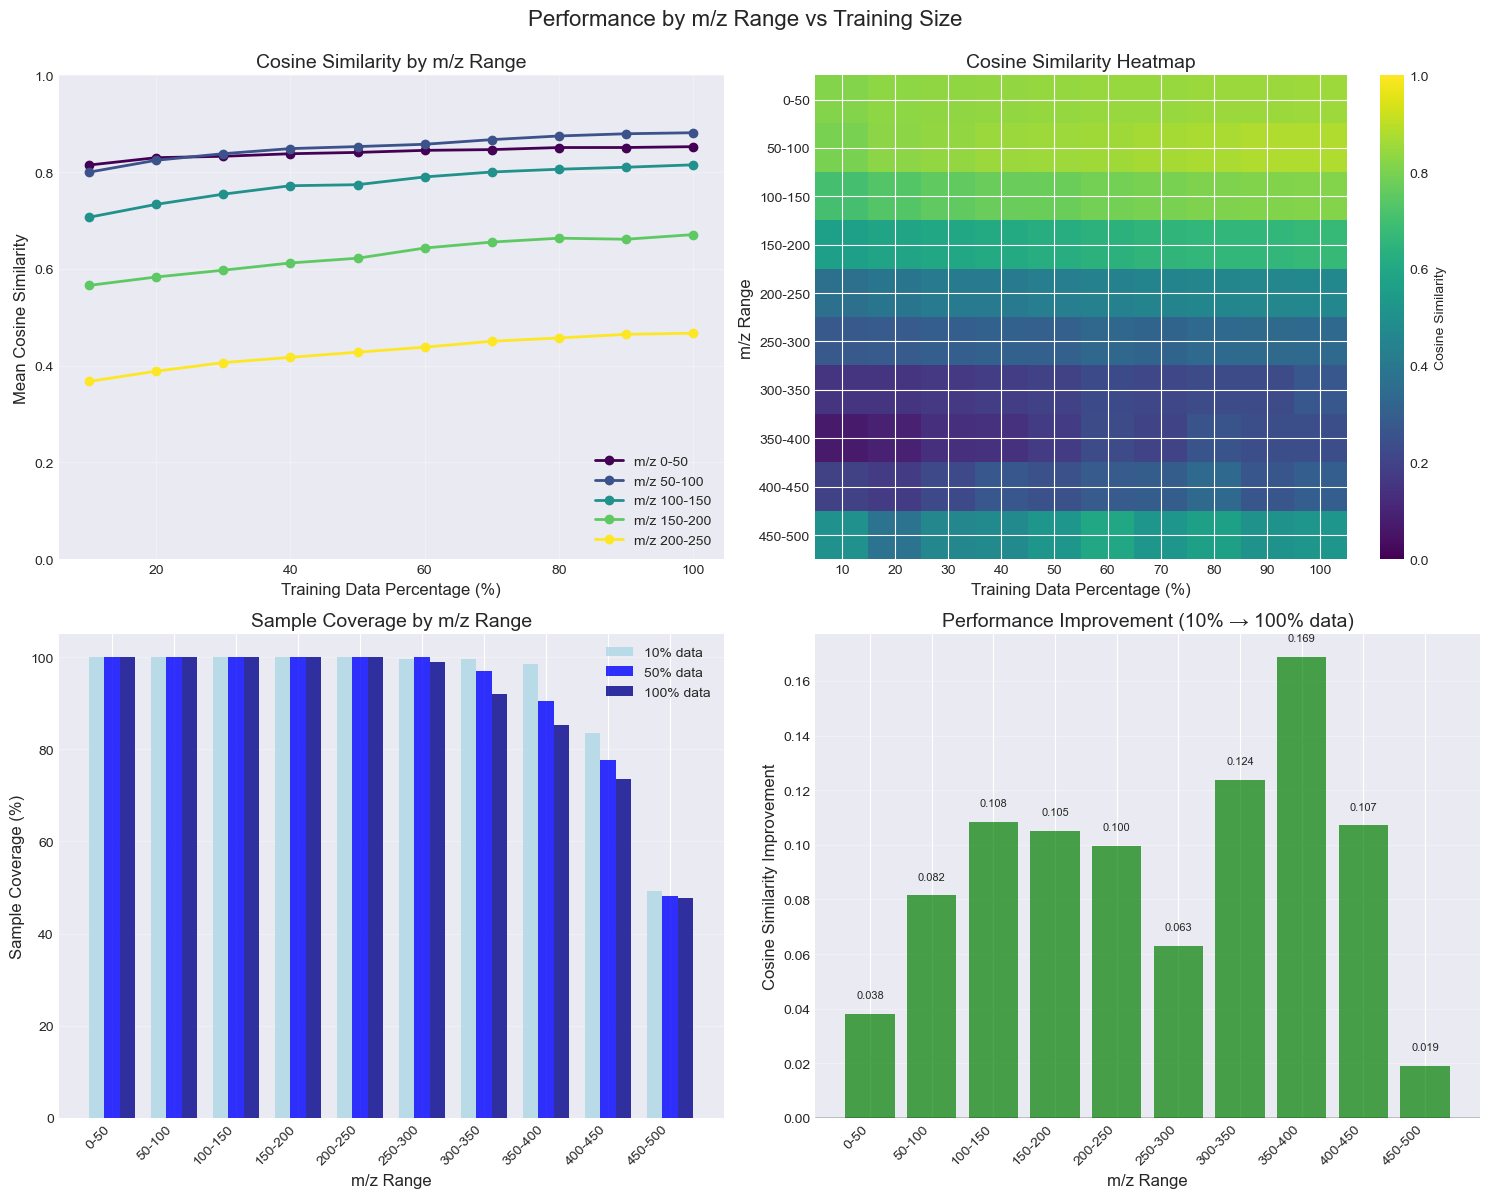


DETAILED ANALYSIS FOR KEY m/z RANGES
------------------------------------------------------------


In [7]:
# Analyze performance by m/z range for each training percentage
print("\nm/z RANGE PERFORMANCE ANALYSIS")
print("=" * 60)

# Extract m/z range data
mz_ranges = list(all_results[percentages[0]]['mz_range_sims'].keys())
mz_performance = {}

# Organize data by m/z range
for mz_range in mz_ranges:
    mz_performance[mz_range] = {
        'cosine_sims': [],
        'coverages': [],
        'pred_peaks': []
    }
    
    for percentage in percentages:
        range_data = all_results[percentage]['mz_range_sims'][mz_range]
        mz_performance[mz_range]['cosine_sims'].append(range_data['mean_similarity'])
        mz_performance[mz_range]['coverages'].append(range_data['coverage'])
        mz_performance[mz_range]['pred_peaks'].append(range_data['avg_pred_peaks_per_spectrum'])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance by m/z Range vs Training Size', fontsize=16, y=0.995)

# 1. Cosine similarity by m/z range
ax1 = axes[0, 0]
# Show first 5 ranges with different colors
colors = plt.cm.viridis(np.linspace(0, 1, 5))
for i, mz_range in enumerate(mz_ranges[:5]):
    ax1.plot(percentages, mz_performance[mz_range]['cosine_sims'], 
             marker='o', label=f'm/z {mz_range}', linewidth=2, 
             markersize=6, color=colors[i])
ax1.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax1.set_ylabel('Mean Cosine Similarity', fontsize=12)
ax1.set_title('Cosine Similarity by m/z Range', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# 2. Heatmap of cosine similarities
ax2 = axes[0, 1]
cosine_matrix = np.array([mz_performance[mz]['cosine_sims'] for mz in mz_ranges])
im = ax2.imshow(cosine_matrix, aspect='auto', cmap='viridis', 
                vmin=0, vmax=1, interpolation='nearest')
ax2.set_xticks(range(len(percentages)))
ax2.set_xticklabels(percentages)
ax2.set_yticks(range(len(mz_ranges)))
ax2.set_yticklabels(mz_ranges)
ax2.set_xlabel('Training Data Percentage (%)', fontsize=12)
ax2.set_ylabel('m/z Range', fontsize=12)
ax2.set_title('Cosine Similarity Heatmap', fontsize=14)
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Cosine Similarity', fontsize=10)

# 3. Coverage analysis
ax3 = axes[1, 0]
selected_percentages = [10, 50, 100]  # Show specific percentages
x = np.arange(len(mz_ranges))
width = 0.25
colors_bar = ['lightblue', 'blue', 'darkblue']

for i, pct in enumerate(selected_percentages):
    if pct in percentages:
        idx = percentages.index(pct)
        coverages = [mz_performance[mz]['coverages'][idx] for mz in mz_ranges]
        ax3.bar(x + i*width, coverages, width, label=f'{pct}% data', 
               color=colors_bar[i], alpha=0.8)

ax3.set_xlabel('m/z Range', fontsize=12)
ax3.set_ylabel('Sample Coverage (%)', fontsize=12)
ax3.set_title('Sample Coverage by m/z Range', fontsize=14)
ax3.set_xticks(x + width)
ax3.set_xticklabels(mz_ranges, rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 105)

# 4. Performance improvement from 10% to 100%
ax4 = axes[1, 1]
improvements = []
for mz_range in mz_ranges:
    improvement = mz_performance[mz_range]['cosine_sims'][-1] - mz_performance[mz_range]['cosine_sims'][0]
    improvements.append(improvement)

colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
bars = ax4.bar(range(len(mz_ranges)), improvements, color=colors_imp, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('m/z Range', fontsize=12)
ax4.set_ylabel('Cosine Similarity Improvement', fontsize=12)
ax4.set_title('Performance Improvement (10% → 100% data)', fontsize=14)
ax4.set_xticks(range(len(mz_ranges)))
ax4.set_xticklabels(mz_ranges, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, v) in enumerate(zip(bars, improvements)):
    ax4.text(i, v + 0.005 * np.sign(v), f'{v:.3f}', 
            ha='center', va='bottom' if v > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

# Print detailed analysis for ranges of interest
print("\nDETAILED ANALYSIS FOR KEY m/z RANGES")
print("-" * 60)
for mz_range in CONFIG['evaluation']['mz_ranges_of_interest']:
    range_str = f"{mz_range[0]}-{mz_range[1]}"
    if range_str in mz_performance:
        perf = mz_performance[range_str]
        print(f"\nm/z {range_str}:")
        print(f"  Cosine @ 10%: {perf['cosine_sims'][0]:.4f}")
        print(f"  Cosine @ 100%: {perf['cosine_sims'][-1]:.4f}")
        print(f"  Improvement: +{perf['cosine_sims'][-1] - perf['cosine_sims'][0]:.4f}")
        print(f"  Coverage: {perf['coverages'][-1]:.1f}% of samples")

## 7. Advanced Diagnostics

In-depth statistical analysis to understand the scaling behavior and optimize data collection strategies.

### 7.1 Learning Efficiency Analysis

Quantifies how efficiently the model uses training data:

**Performance per Sample**:
$$\text{Efficiency} = \frac{\text{Cosine Similarity}}{\text{N Samples}} \times 1000$$

**Data Efficiency**:
$$\text{Data Efficiency} = \frac{\text{Performance} / \text{Max Performance}}{\text{Data\%} / 100}$$

Values > 1 indicate super-linear scaling (rare but valuable).

### 7.2 Saturation Analysis

Fits logarithmic curve to identify performance saturation:
$$\text{Performance}(n) = a \cdot \log(b \cdot n + 1) + c$$

Where:
- $a$ = scaling factor
- $b$ = growth rate
- $c$ = baseline performance

### 7.3 Feature Importance Stability

Analyzes whether feature importances remain consistent across data sizes.
High correlation (>0.9) indicates stable feature selection.

### 7.4 Error Distribution Analysis

Examines:
- Distribution shape changes
- Percentile progression
- Variance reduction
- Difficult sample identification

### 7.5 Statistical Significance Testing

Uses Mann-Whitney U test to verify performance improvements are statistically significant:
- Null hypothesis: No difference in cosine similarity distributions
- Alternative: Larger dataset yields better performance
- Significance level: α = 0.05


ADVANCED DIAGNOSTICS ANALYSIS

1. LEARNING EFFICIENCY METRICS
----------------------------------------
 Percentage  N_Samples  Cosine  Perf/1K_Samples  Rel_Improvement_%  Data_Efficiency
         10        217   0.653            3.007              0.000            8.381
         20        435   0.686            1.578              5.170            4.407
         30        652   0.705            1.081              8.052            3.019
         40        870   0.723            0.831             10.789            2.321
         50       1088   0.731            0.672             12.016            1.878
         60       1305   0.745            0.571             14.229            1.596
         70       1523   0.758            0.498             16.120            1.390
         80       1740   0.767            0.441             17.479            1.231
         90       1958   0.773            0.395             18.531            1.104
        100       2176   0.779            0.358         

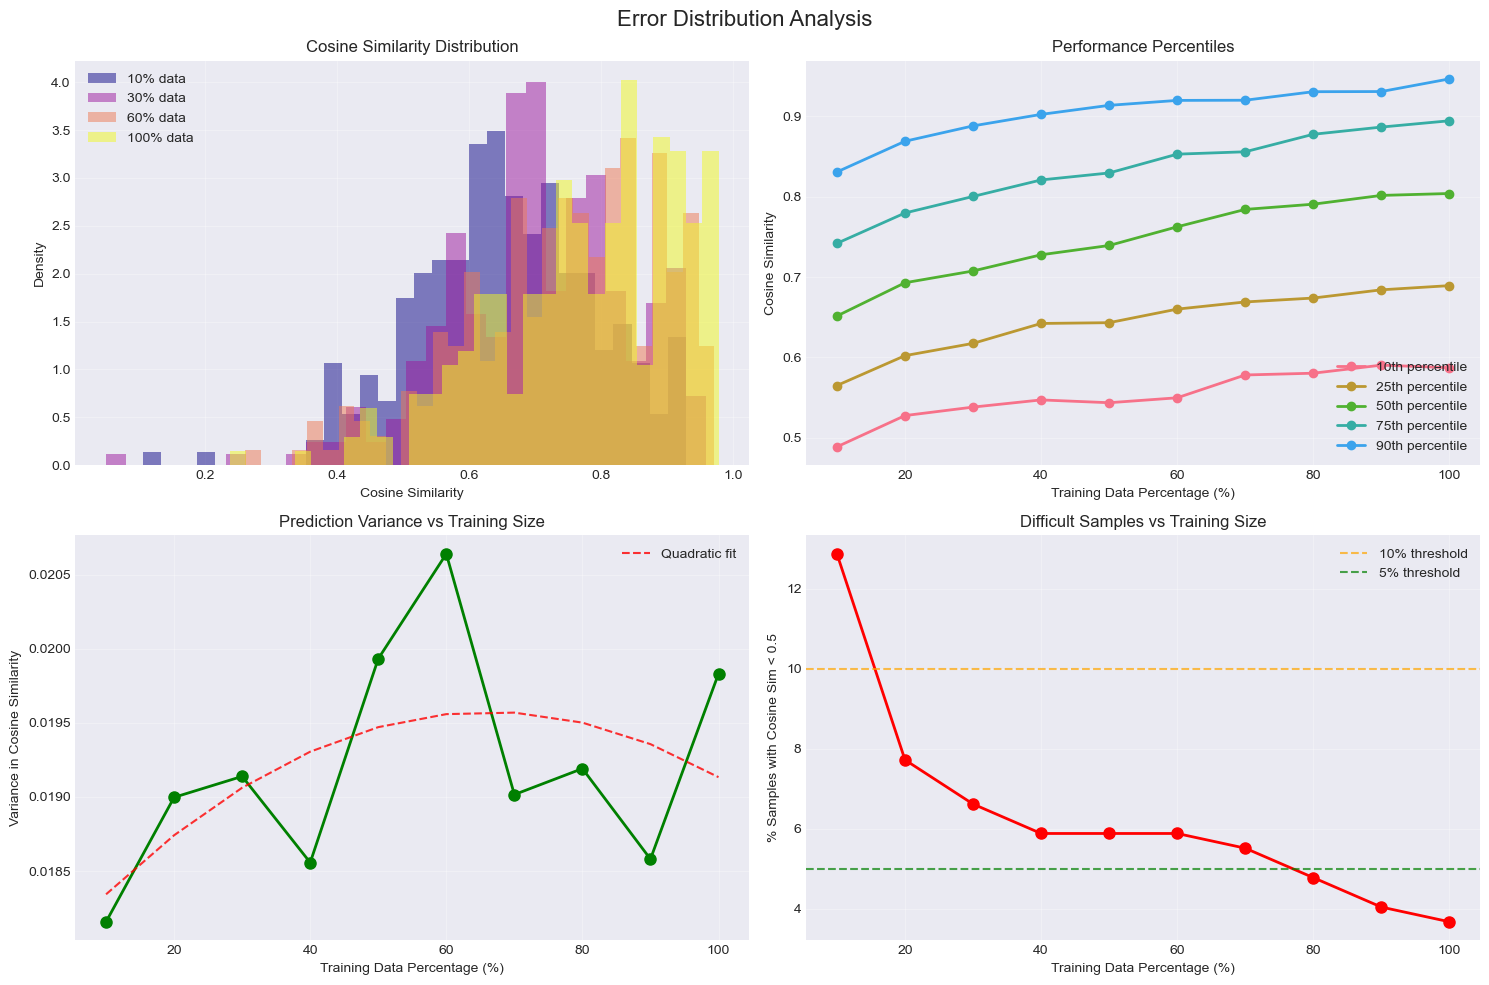



5. STATISTICAL SIGNIFICANCE TESTING
----------------------------------------
Testing if performance differences are statistically significant
(Mann-Whitney U test, alternative='less')

Comparison        | p-value  | Significant (α=0.05) | Effect Size
-----------------------------------------------------------------
10% vs 30% | 0.000002 | Yes                  | 0.231
30% vs 60% | 0.000114 | Yes                  | 0.183
60% vs 100% | 0.002470 | Yes                  | 0.139
10% vs 100% | 0.000000 | Yes                  | 0.495

Effect size interpretation:
  Small: 0.1-0.3, Medium: 0.3-0.5, Large: >0.5


6. SUMMARY STATISTICS
----------------------------------------
Minimum cosine similarity: 0.6525 at 10%
Maximum cosine similarity: 0.7786 at 100%
Total improvement: 0.1260
Average improvement per 10%: 0.0140


In [8]:
print("\nADVANCED DIAGNOSTICS ANALYSIS")
print("=" * 60)

# 1. Learning Efficiency Analysis
print("\n1. LEARNING EFFICIENCY METRICS")
print("-" * 40)

# Calculate efficiency metrics
baseline_cosine = cosine_scores[0]  # 10% performance
max_cosine = max(cosine_scores)

efficiency_metrics = []
for i, (pct, cs, n) in enumerate(zip(percentages, cosine_scores, n_samples)):
    # Performance per sample (normalized)
    perf_per_sample = cs / n * 1000  # Scale for readability
    
    # Relative improvement from baseline
    rel_improvement = (cs - baseline_cosine) / baseline_cosine * 100 if baseline_cosine > 0 else 0
    
    # Data efficiency (% of max performance / % of data)
    data_efficiency = (cs / max_cosine) / (pct / 100) if max_cosine > 0 else 0
    
    efficiency_metrics.append({
        'Percentage': pct,
        'N_Samples': n,
        'Cosine': cs,
        'Perf/1K_Samples': perf_per_sample,
        'Rel_Improvement_%': rel_improvement,
        'Data_Efficiency': data_efficiency
    })

efficiency_df = pd.DataFrame(efficiency_metrics)
print(efficiency_df.round(3).to_string(index=False))

# Identify most efficient data point
max_efficiency_idx = efficiency_df['Data_Efficiency'].idxmax()
print(f"\nMost data-efficient point: {efficiency_df.loc[max_efficiency_idx, 'Percentage']}% "
      f"(efficiency: {efficiency_df.loc[max_efficiency_idx, 'Data_Efficiency']:.3f})")

# 2. Saturation Analysis
print("\n\n2. PERFORMANCE SATURATION ANALYSIS")
print("-" * 40)

# Fit logarithmic curve to find saturation point
from scipy.optimize import curve_fit

def log_curve(x, a, b, c):
    """Logarithmic growth model."""
    return a * np.log(b * x + 1) + c

try:
    # Fit the curve
    popt, pcov = curve_fit(log_curve, n_samples, cosine_scores, 
                          p0=[0.1, 0.0001, 0.5], maxfev=5000)
    
    # Calculate R² for fit quality
    residuals = cosine_scores - log_curve(np.array(n_samples), *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((cosine_scores - np.mean(cosine_scores))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Predict performance for larger datasets
    future_samples = np.linspace(n_samples[-1], n_samples[-1] * 2, 10)
    future_performance = log_curve(future_samples, *popt)
    
    # Find diminishing returns threshold (where gain < 1% per 10% more data)
    gains_threshold = 0.001  # 0.1% improvement
    saturation_point = None
    
    for i in range(1, len(percentages)):
        gain_per_10pct = (cosine_scores[i] - cosine_scores[i-1]) / (percentages[i] - percentages[i-1]) * 10
        if gain_per_10pct < gains_threshold:
            saturation_point = percentages[i-1]
            break
    
    print(f"Logarithmic fit: Performance = {popt[0]:.4f} * log({popt[1]:.6f} * n + 1) + {popt[2]:.4f}")
    print(f"Fit quality (R²): {r_squared:.4f}")
    print(f"\nCurrent maximum performance: {max_cosine:.4f}")
    print(f"Predicted at 2x data ({int(n_samples[-1]*2):,} samples): {future_performance[-1]:.4f}")
    print(f"Expected improvement: +{future_performance[-1] - max_cosine:.4f}")
    
    if saturation_point:
        print(f"\nDiminishing returns threshold reached at: {saturation_point}% of data")
    else:
        print("\nNo saturation detected - performance still improving significantly")
    
except Exception as e:
    print(f"Could not fit logarithmic curve: {e}")

# 3. Feature Importance Stability
print("\n\n3. FEATURE IMPORTANCE STABILITY")
print("-" * 40)

# Compare feature importances across different training sizes
selected_pcts = [10, 50, 100]
feature_importances = {}

print("Extracting feature importances...")
for pct in selected_pcts:
    if pct in percentages:
        model = models_info[pct]['model']
        feature_importances[pct] = model.feature_importances_

# Calculate correlation between feature importances
print("\nFeature importance correlation matrix:")
importance_corr = pd.DataFrame(index=selected_pcts, columns=selected_pcts, dtype=float)

for pct1 in selected_pcts:
    for pct2 in selected_pcts:
        if pct1 in feature_importances and pct2 in feature_importances:
            corr = np.corrcoef(feature_importances[pct1], feature_importances[pct2])[0, 1]
            importance_corr.loc[pct1, pct2] = corr

print(importance_corr.round(3))
print("\nInterpretation:")
print("  - High correlation (>0.9): Feature importance is stable across data sizes")
print("  - Low correlation (<0.7): Different features become important with more data")

# 4. Error Distribution Analysis
print("\n\n4. ERROR DISTRIBUTION ANALYSIS")
print("-" * 40)

# Analyze cosine similarity distribution for different training sizes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Error Distribution Analysis', fontsize=16)

# Plot 1: Cosine similarity distributions
ax1 = axes[0, 0]
colors = plt.cm.plasma(np.linspace(0, 1, 4))
for i, pct in enumerate([10, 30, 60, 100]):
    if pct in percentages:
        cos_sims = all_results[pct]['individual_cos_sims']
        ax1.hist(cos_sims, bins=30, alpha=0.5, label=f'{pct}% data', 
                density=True, color=colors[i])

ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Density')
ax1.set_title('Cosine Similarity Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Percentile analysis
ax2 = axes[0, 1]
percentiles_to_plot = [10, 25, 50, 75, 90]
for i, percentile in enumerate(percentiles_to_plot):
    values = [np.percentile(all_results[p]['individual_cos_sims'], percentile) 
              for p in percentages]
    ax2.plot(percentages, values, marker='o', label=f'{percentile}th percentile', 
            linewidth=2, markersize=6)

ax2.set_xlabel('Training Data Percentage (%)')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Performance Percentiles')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# Plot 3: Variance analysis
ax3 = axes[1, 0]
variances = [np.var(all_results[p]['individual_cos_sims']) for p in percentages]
ax3.plot(percentages, variances, 'go-', markersize=8, linewidth=2)
ax3.set_xlabel('Training Data Percentage (%)')
ax3.set_ylabel('Variance in Cosine Similarity')
ax3.set_title('Prediction Variance vs Training Size')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(percentages, variances, 2)
p = np.poly1d(z)
ax3.plot(percentages, p(percentages), "r--", alpha=0.8, label='Quadratic fit')
ax3.legend()

# Plot 4: Difficult samples analysis
ax4 = axes[1, 1]
poor_performance_threshold = 0.5  # Cosine similarity < 0.5
poor_performance_pcts = []

for pct in percentages:
    cos_sims = all_results[pct]['individual_cos_sims']
    poor_pct = np.sum(cos_sims < poor_performance_threshold) / len(cos_sims) * 100
    poor_performance_pcts.append(poor_pct)

ax4.plot(percentages, poor_performance_pcts, 'ro-', markersize=8, linewidth=2)
ax4.set_xlabel('Training Data Percentage (%)')
ax4.set_ylabel('% Samples with Cosine Sim < 0.5')
ax4.set_title('Difficult Samples vs Training Size')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=10, color='orange', linestyle='--', alpha=0.7, label='10% threshold')
ax4.axhline(y=5, color='green', linestyle='--', alpha=0.7, label='5% threshold')
ax4.legend()

plt.tight_layout()
plt.show()

# 5. Statistical Significance Testing
print("\n\n5. STATISTICAL SIGNIFICANCE TESTING")
print("-" * 40)
print("Testing if performance differences are statistically significant")
print("(Mann-Whitney U test, alternative='less')")
print("\nComparison        | p-value  | Significant (α=0.05) | Effect Size")
print("-" * 65)

comparisons = [(10, 30), (30, 60), (60, 100), (10, 100)]
for pct1, pct2 in comparisons:
    if pct1 in percentages and pct2 in percentages:
        cos_sims1 = all_results[pct1]['individual_cos_sims']
        cos_sims2 = all_results[pct2]['individual_cos_sims']
        
        # Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(cos_sims1, cos_sims2, 
                                               alternative='less')
        significant = "Yes" if p_value < 0.05 else "No"
        
        # Calculate effect size (rank-biserial correlation)
        n1, n2 = len(cos_sims1), len(cos_sims2)
        effect_size = 1 - (2 * statistic) / (n1 * n2)
        
        print(f"{pct1}% vs {pct2}% | {p_value:.6f} | {significant:<20} | {effect_size:.3f}")

print("\nEffect size interpretation:")
print("  Small: 0.1-0.3, Medium: 0.3-0.5, Large: >0.5")

# Summary statistics
print("\n\n6. SUMMARY STATISTICS")
print("-" * 40)
print(f"Minimum cosine similarity: {min(cosine_scores):.4f} at {percentages[cosine_scores.index(min(cosine_scores))]}%")
print(f"Maximum cosine similarity: {max(cosine_scores):.4f} at {percentages[cosine_scores.index(max(cosine_scores))]}%")
print(f"Total improvement: {max(cosine_scores) - min(cosine_scores):.4f}")
print(f"Average improvement per 10%: {(max(cosine_scores) - min(cosine_scores)) / 9:.4f}")